<a href="https://colab.research.google.com/github/IMrCherryPie/vehicle-number-recognition/blob/master/dl_image_dataset_loading.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Загрузка собственного набора изображений в TensorFlow и Keras

Чтобы запускать и редактировать код, сохраните копию этого ноутбука себе (Файл -> Создать копию на Диске). Свою копию вы сможете изменять и запускать.

Не забудьте подключить GPU для ускорения обучения нейронной сети (Среда Выполнения -> Сменить среду выполнения -> Аппаратный ускоритель -> GPU).

## Набор данных

В качестве примера собственного набора данных используется [symbols](https://drive.google.com/file/d/1e8LJOgPgkxCS3YkWXa7YW38ku_XAtlaJ/view?usp=sharing) - набор фрагментов изображения номерных знаков (символов на знаке).

**Количество классов в наборе данных**: 21. 


**Размеры изображений**: 100х100. 

**Формат изображений**: bmp.

In [26]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras import utils
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing import image_dataset_from_directory
import matplotlib.pyplot as plt
from google.colab import files
%matplotlib inline 

## Загружаем данные

In [28]:
!wget https://drive.google.com/drive/folders/153RNb1-aA00VbVUIOt14gAx073vWDE42?usp=sharing -O master.zip

--2022-04-04 14:57:11--  https://drive.google.com/drive/folders/153RNb1-aA00VbVUIOt14gAx073vWDE42?usp=sharing
Resolving drive.google.com (drive.google.com)... 173.194.76.100, 173.194.76.102, 173.194.76.139, ...
Connecting to drive.google.com (drive.google.com)|173.194.76.100|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘symbols.zip’

symbols.zip             [  <=>               ] 209.67K   894KB/s    in 0.2s    

2022-04-04 14:57:12 (894 KB/s) - ‘symbols.zip’ saved [214705]



In [30]:
!unzip symbols.zip

Выходные данные были обрезаны до нескольких последних строк (5000).
 extracting: symbols/Training/B/726.bmp  
 extracting: symbols/Training/B/727.bmp  
 extracting: symbols/Training/B/728.bmp  
 extracting: symbols/Training/B/729.bmp  
 extracting: symbols/Training/B/73.bmp  
 extracting: symbols/Training/B/730.bmp  
 extracting: symbols/Training/B/731.bmp  
 extracting: symbols/Training/B/732.bmp  
 extracting: symbols/Training/B/733.bmp  
 extracting: symbols/Training/B/734.bmp  
 extracting: symbols/Training/B/735.bmp  
 extracting: symbols/Training/B/736.bmp  
 extracting: symbols/Training/B/737.bmp  
 extracting: symbols/Training/B/738.bmp  
 extracting: symbols/Training/B/739.bmp  
 extracting: symbols/Training/B/74.bmp  
 extracting: symbols/Training/B/740.bmp  
 extracting: symbols/Training/B/741.bmp  
 extracting: symbols/Training/B/742.bmp  
 extracting: symbols/Training/B/743.bmp  
 extracting: symbols/Training/B/744.bmp  
 extracting: symbols/Training/B/745.bmp  
 extractin

## Создаем Tensorflow Dataset'ы 

In [31]:
batch_size=256
image_size=(100, 100)

**Набор данных для обучения**

In [32]:
train_dataset = image_dataset_from_directory('symbols/Training',
                                             subset='training',
                                             seed=42,
                                             validation_split=0.1,
                                             batch_size=batch_size,
                                             image_size=image_size)

Found 14008 files belonging to 21 classes.
Using 12608 files for training.


**Проверочный набор данных**

In [33]:
validation_dataset = image_dataset_from_directory('symbols/Training',
                                             subset='validation',
                                             seed=42,
                                             validation_split=0.1,
                                             batch_size=batch_size,
                                             image_size=image_size)

Found 14008 files belonging to 21 classes.
Using 1400 files for validation.


Названия классов в наборах данных.

In [34]:
class_names = train_dataset.class_names
class_names

['0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 'A',
 'B',
 'C',
 'E',
 'H',
 'K',
 'M',
 'P',
 'T',
 'X',
 'Y']

**Примеры изображений**

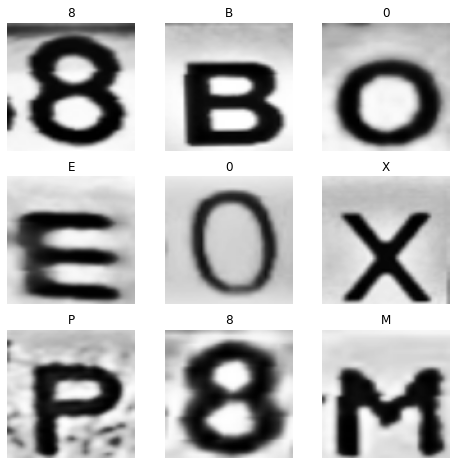

In [35]:
plt.figure(figsize=(8, 8))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

**Набор данных для тестирования**

In [36]:
test_dataset = image_dataset_from_directory('symbols/Test',
                                             batch_size=batch_size,
                                             image_size=image_size)

Found 1739 files belonging to 21 classes.


In [37]:
test_dataset.class_names

['0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 'A',
 'B',
 'C',
 'E',
 'H',
 'K',
 'M',
 'P',
 'T',
 'X',
 'Y']

## Настраиваем производительность TensorFlow DataSet'ов

In [38]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

## Создаем нейронную сеть

In [39]:
# Создаем последовательную модель
model = Sequential()
# Сверточный слой
model.add(Conv2D(16, (5, 5), padding='same', 
                 input_shape=(100, 100, 3), activation='relu'))
# Слой подвыборки
model.add(MaxPooling2D(pool_size=(2, 2)))
# Сверточный слой
model.add(Conv2D(32, (5, 5), activation='relu', padding='same'))
# Слой подвыборки
model.add(MaxPooling2D(pool_size=(2, 2)))
# Сверточный слой
model.add(Conv2D(64, (5, 5), activation='relu', padding='same'))
# Слой подвыборки
model.add(MaxPooling2D(pool_size=(2, 2)))
# Сверточный слой
model.add(Conv2D(128, (5, 5), activation='relu', padding='same'))
# Слой подвыборки
model.add(MaxPooling2D(pool_size=(2, 2)))
# Полносвязная часть нейронной сети для классификации
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
# Выходной слой, 21 нейрон по количеству классов
model.add(Dense(21, activation='softmax'))

**Компилируем модель**

In [40]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

## Обучаем нейронную сеть

In [41]:
history = model.fit(train_dataset, 
                    validation_data=validation_dataset,
                    epochs=5,
                    verbose=2)

Epoch 1/5
50/50 - 20s - loss: 4.4466 - accuracy: 0.6786 - val_loss: 0.0386 - val_accuracy: 0.9914 - 20s/epoch - 404ms/step
Epoch 2/5
50/50 - 10s - loss: 0.0336 - accuracy: 0.9917 - val_loss: 0.0281 - val_accuracy: 0.9936 - 10s/epoch - 193ms/step
Epoch 3/5
50/50 - 11s - loss: 0.0163 - accuracy: 0.9954 - val_loss: 0.0374 - val_accuracy: 0.9950 - 11s/epoch - 216ms/step
Epoch 4/5
50/50 - 9s - loss: 0.0166 - accuracy: 0.9962 - val_loss: 0.0423 - val_accuracy: 0.9950 - 9s/epoch - 180ms/step
Epoch 5/5
50/50 - 9s - loss: 0.0117 - accuracy: 0.9967 - val_loss: 0.0275 - val_accuracy: 0.9964 - 9s/epoch - 179ms/step


## Оцениваем качетсво обучения сети

In [42]:
# Оцениваем качество обучения модели на тестовых данных
scores = model.evaluate(test_dataset, verbose=1)

7/7 [==============================] - 2s 133ms/step - loss: 0.0226 - accuracy: 0.9954


In [43]:
print("Доля верных ответов на тестовых данных, в процентах:", round(scores[1] * 100, 4))

Доля верных ответов на тестовых данных, в процентах: 99.54


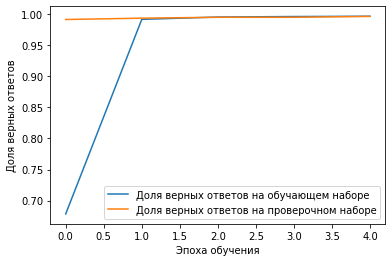

In [44]:
plt.plot(history.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

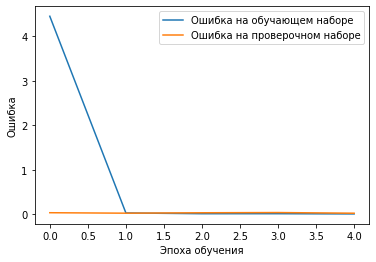

In [45]:
plt.plot(history.history['loss'], 
         label='Ошибка на обучающем наборе')
plt.plot(history.history['val_loss'], 
         label='Ошибка на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Ошибка')
plt.legend()
plt.show()

## Сохраняем обученную нейронную сеть

In [ ]:
model.save("symbols_model.h5")

Сохраняем модель на локальный компьютер

In [ ]:
files.download("symbols_model.h5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>